# Inspect Outer Optimization Runs

Requirement: Run `python -m dacboenv.experiment.collect_incumbents <rundir>`

dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret_Ibbob2d_3seeds


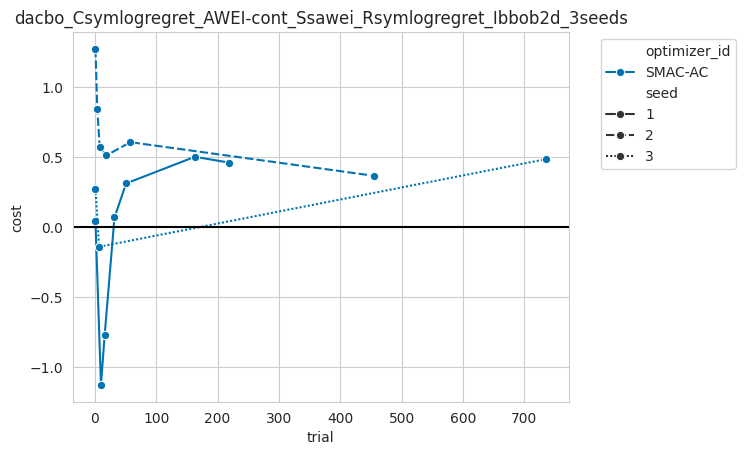

dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret_Ibbob2d_fid8_3seeds


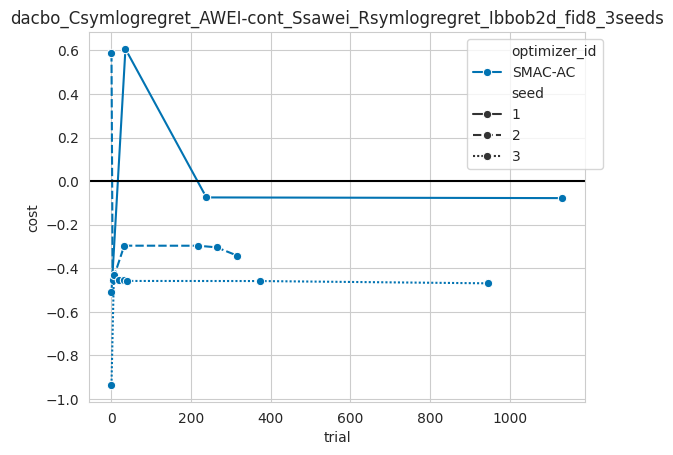

In [63]:

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from carps.analysis.utils import setup_seaborn
import importlib
import dacboenv.experiment.collect_incumbents as ci
importlib.reload(ci)
from dacboenv.experiment.collect_incumbents import gather_data_smac

rundir = Path("../runs/SMAC-AC")

# gather_data_smac(rundir)

trajectory_df = pd.read_csv(rundir / "trajectory.csv")
configs_inc_df = pd.read_csv(rundir / "configs_inc.csv")

setup_seaborn()
for task_id, group in trajectory_df.groupby("task_id"):
    if "sawei" not in task_id:
        continue
    if "symlog" not in task_id:
        continue
    print(task_id)
    ax = sns.lineplot(data=group, x="trial", y="cost", hue="optimizer_id", style="seed", marker="o")
    ax.axhline(0, color="black")
    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_title(task_id)
    plt.show()

[PosixPath('../runs/SMAC-AC/DACBO/dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret_Ibbob2d_3seeds/3/3/smac3_output/adc6195dc5117200e69a83c5f0fd312c/3'), PosixPath('../runs/SMAC-AC/DACBO/dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret_Ibbob2d_3seeds/1/1/smac3_output/0ad74fa09197cec5a16128c130cbf22a/1'), PosixPath('../runs/SMAC-AC/DACBO/dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret_Ibbob2d_3seeds/2/2/smac3_output/513de49a6abeb917eb594a95cf34e833/2')]


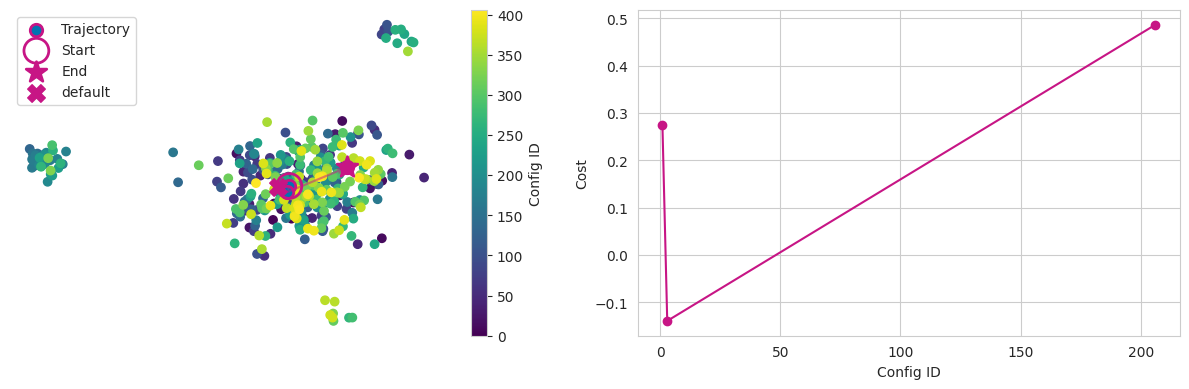

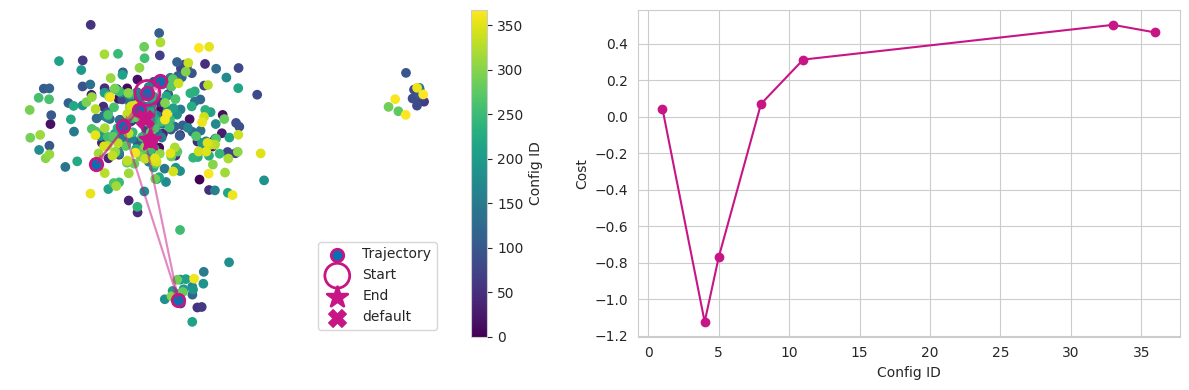

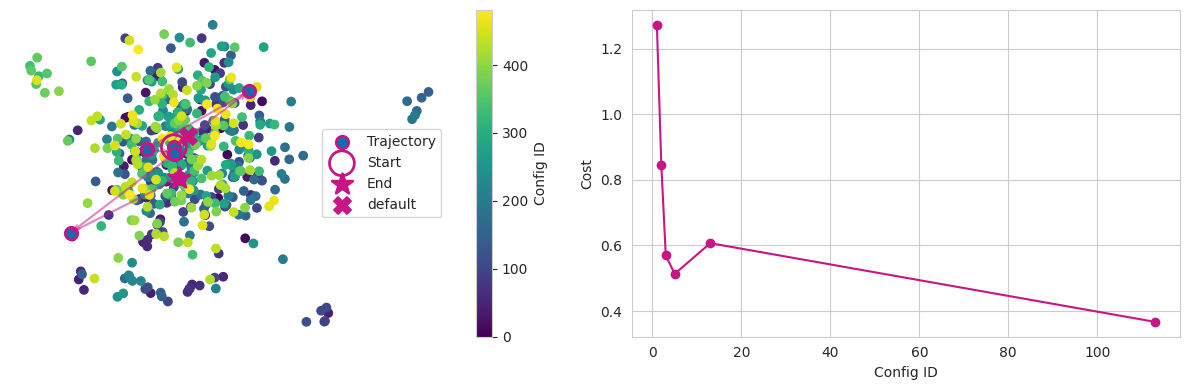

In [70]:
from smac.runhistory.runhistory import RunHistory
from ConfigSpace import ConfigurationSpace
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import json
from dacboenv.policy.policy import AlphaRuleNet

_intensifier_fn = "intensifier.json"

smac_run_dir = Path("../runs/SMAC-AC/DACBO/dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret_Ibbob2d_3seeds/1/1/smac3_output/0ad74fa09197cec5a16128c130cbf22a/1")

rundir = Path("../runs/SMAC-AC/DACBO/dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret_Ibbob2d_3seeds")
smac_run_dirs = list(rundir.glob("**/intensifier.json"))
run_dirs = []
for p in smac_run_dirs:
    if (p.parent.parent.parent / "dask-scratch-space").is_dir():
        run_dirs.append(p.parent)
print(run_dirs)

for smac_run_dir in run_dirs:
    configspace = ConfigurationSpace.from_json(smac_run_dir / "configspace.json")

    rh = RunHistory()
    rh.load(smac_run_dir / "runhistory.json", configspace=configspace)
    configs = rh.get_configs()

    with open(smac_run_dir / _intensifier_fn) as file:
        intensifier_info = json.load(file)
    trajectory = pd.DataFrame(intensifier_info["trajectory"])
    trajectory["cost"] = trajectory["costs"].map(lambda x: x[0])
    trajectory["config_id"] = trajectory["config_ids"].map(lambda x: x[0])
    del trajectory["costs"]
    del trajectory["config_ids"]
    trajectory["config"] = trajectory["config_id"].map(rh.get_config)

    X = np.array([list(dict(c).values()) for c in configs])

    scaler = StandardScaler().fit(X)
    X_norm = scaler.transform(X)
    pca = PCA(
        n_components=2,
        random_state=42
    ).fit(X_norm)
    X_pca = pca.transform(X_norm)




    X_traj = np.array([list(dict(c).values()) for c in trajectory["config"]])
    X_traj_norm = scaler.transform(X_traj)
    X_traj_pca = pca.transform(X_traj_norm)

    default_weights = AlphaRuleNet.alpha_rule_init_weights().numpy()
    w_def = default_weights[None, :]
    X_def_norm = scaler.transform(w_def)
    X_def_pca = pca.transform(X_def_norm)


    ###### PLOT

    fig = plt.figure(figsize=(12, 4))
    axes = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False)

    ax = axes[0]
    sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=range(len(X_pca)), cmap="viridis")

    x = X_traj_pca[:, 0]
    y = X_traj_pca[:, 1]
    dx = np.diff(x)
    dy = np.diff(y)

    arrow_width = 0.005
    label = "Trajectory"
    point_size = 40
    color = "mediumvioletred"

    # Scatter points
    ax.scatter(
        x,
        y,
        s=point_size * 2,
        facecolor=None,
        # alpha=0.8,
        label=label,
        edgecolor=color,
        linewidth=2
    )

    # Quiver arrows (time direction)
    ax.quiver(
        x[:-1],
        y[:-1],
        dx,
        dy,
        angles="xy",
        scale_units="xy",
        scale=1,
        width=arrow_width,
        color=color,
        alpha=0.5,
    )

    # Start marker
    ax.scatter(
        x[0],
        y[0],
        marker="o",
        s=point_size * 8,
        facecolors="none",
        edgecolors=color,
        linewidths=2,
        label="Start"
    )

    # End marker
    ax.scatter(
        x[-1],
        y[-1],
        marker="*",
        s=point_size * 6,
        color=color,
        linewidths=2,
        label="End"
    )


    ax.scatter(X_def_pca[:, 0], X_def_pca[:, 1], color="mediumvioletred", marker="X", s=point_size * 4, label="default")
    ax.legend()
    ax.axes.set_axis_off()
    fig.colorbar(sc, ax=ax, label="Config ID")

    ax = axes[1]
    ax.plot(trajectory["config_id"], trajectory["cost"], marker="o", color=color, label="Trajectory")
    ax.set_xlabel("Config ID")
    ax.set_ylabel("Cost")
    fig.tight_layout()
    plt.show()


Found 3 run directories.


/tmp/ipykernel_1515848/3761119022.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  run_cmap = cm.get_cmap("tab10", n_runs)  # categorical colormap


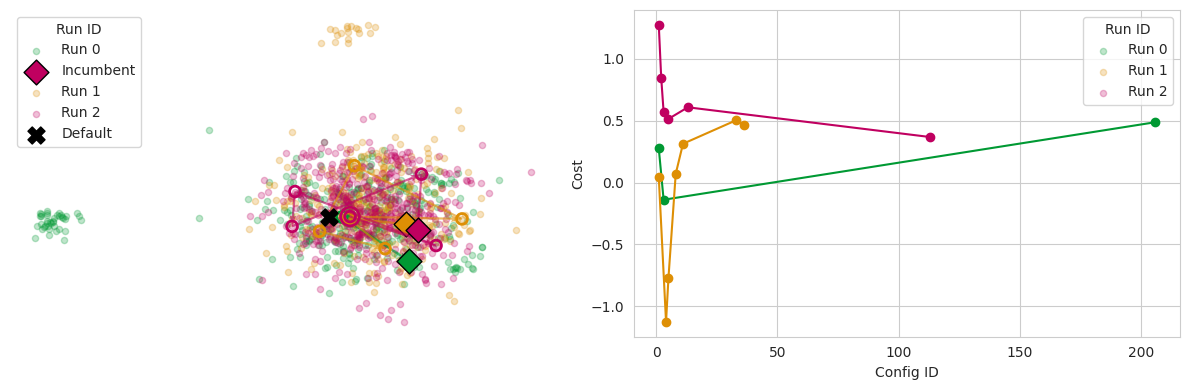

In [87]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from smac.runhistory.runhistory import RunHistory
from ConfigSpace import ConfigurationSpace
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from dacboenv.policy.policy import AlphaRuleNet
from matplotlib.colors import ListedColormap

# ------------------------------
# PARAMETERS
# ------------------------------
rundir = Path("../runs/SMAC-AC/DACBO/dacbo_Csymlogregret_AWEI-cont_Ssawei_Rsymlogregret_Ibbob2d_3seeds")
_intensifier_fn = "intensifier.json"

# ------------------------------
# FIND RUN DIRECTORIES
# ------------------------------
smac_run_dirs = list(rundir.glob("**/intensifier.json"))
run_dirs = [p.parent for p in smac_run_dirs if (p.parent.parent.parent / "dask-scratch-space").is_dir()]
print(f"Found {len(run_dirs)} run directories.")

# ------------------------------
# COLLECT ALL DATA
# ------------------------------
all_X = []
run_data = []

for run_id, smac_run_dir in enumerate(run_dirs):
    # Load ConfigSpace
    configspace = ConfigurationSpace.from_json(smac_run_dir / "configspace.json")

    # Load RunHistory
    rh = RunHistory()
    rh.load(smac_run_dir / "runhistory.json", configspace=configspace)
    configs = rh.get_configs()

    # Load trajectory info
    with open(smac_run_dir / _intensifier_fn) as f:
        intensifier_info = json.load(f)
    trajectory = pd.DataFrame(intensifier_info["trajectory"])
    trajectory["cost"] = trajectory["costs"].map(lambda x: x[0])
    trajectory["config_id"] = trajectory["config_ids"].map(lambda x: x[0])
    trajectory["config"] = trajectory["config_id"].map(rh.get_config)

    # Convert configs to array
    X = np.array([list(dict(c).values()) for c in configs])
    X_traj = np.array([list(dict(c).values()) for c in trajectory["config"]])

    run_data.append({
        "X": X,
        "X_traj": X_traj,
        "trajectory": trajectory,
        "run_id": run_id
    })

    all_X.append(X)

# Stack all configs globally
X_all = np.vstack(all_X)

# ------------------------------
# GLOBAL SCALER + PCA
# ------------------------------
scaler = StandardScaler().fit(X_all)
pca = PCA(n_components=2, random_state=42).fit(scaler.transform(X_all))

# ------------------------------
# PLOTTING
# ------------------------------
fig = plt.figure(figsize=(12,4))
axes = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False)


ax = axes[0]

n_runs = len(run_data)
run_cmap = cm.get_cmap("tab10", n_runs)  # categorical colormap
sample_colors = ["#009933", "#de8f05ff", "#C00060"]
run_cmap = ListedColormap(sample_colors, name="custom_run_colors")


for data in run_data:
    run_id = data["run_id"]
    color = run_cmap(run_id)

    # Transform data
    X_pca = pca.transform(scaler.transform(data["X"]))
    X_traj_pca = pca.transform(scaler.transform(data["X_traj"]))

    # Background configs
    ax.scatter(
        X_pca[:, 0], X_pca[:, 1],
        color=color, alpha=0.25, s=20, label=f"Run {run_id}"
    )

    # Trajectory
    x, y = X_traj_pca[:, 0], X_traj_pca[:, 1]
    dx, dy = np.diff(x), np.diff(y)

    ax.scatter(
        x, y,
        facecolors="none",
        edgecolors=color,
        linewidths=2,
        s=60,
        zorder=9999
    )

    ax.quiver(
        x[:-1], y[:-1], dx, dy,
        angles="xy",
        scale_units="xy",
        scale=1,
        width=0.004,
        color=color,
        alpha=0.6,
        zorder=9999
    )

    # Start / End points
    ax.scatter(
        x[0], y[0],
        marker="o", s=180,
        facecolors="none",
        edgecolors=color,
        linewidths=2,
        zorder=9999
    )
    ax.scatter(
        x[-1], y[-1],
        marker="D", s=160,
        color=color,
        facecolors=color,
        edgecolors="black",
        zorder=9999,
        label="Incumbent"
    )

# Default configuration
default_weights = AlphaRuleNet.alpha_rule_init_weights().numpy()[None, :]
X_def_pca = pca.transform(scaler.transform(default_weights))
ax.scatter(
    X_def_pca[:, 0],
    X_def_pca[:, 1],
    marker="X", s=150,
    color="black",
    label="Default",
    zorder=99999
)

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Run ID")

ax.set_axis_off()

ax = axes[1]
for data in run_data:
    run_id = data["run_id"]
    color = run_cmap(run_id)

    trajectory = data["trajectory"]

    ax.plot(trajectory["config_id"], trajectory["cost"], marker="o", color=color, label="Trajectory")
ax.set_xlabel("Config ID")
ax.set_ylabel("Cost")

# Legend
by_label = {l: h for l, h in zip(labels[:-1], handles[:-1]) if l != "Incumbent"}
ax.legend(by_label.values(), by_label.keys(), title="Run ID")

fig.tight_layout()
plt.show()


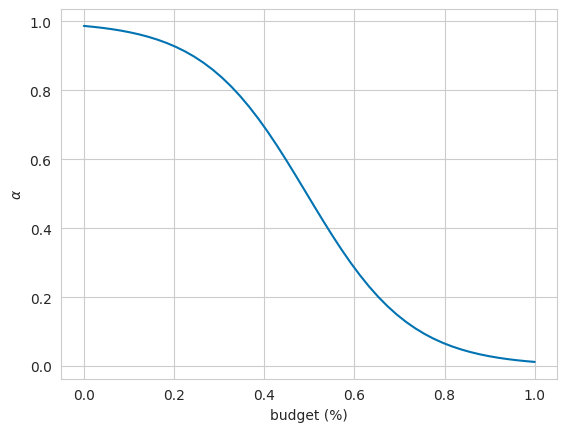

In [2]:
import numpy as np
from dacboenv.utils.math import sigmoid
X = np.linspace(0, 1)
y = sigmoid(-8.7 * X + 4.3)
plt.plot(X, y)
plt.xlabel("budget (%)")
plt.ylabel("$\\alpha$")
plt.show()

['w0', 'w1']


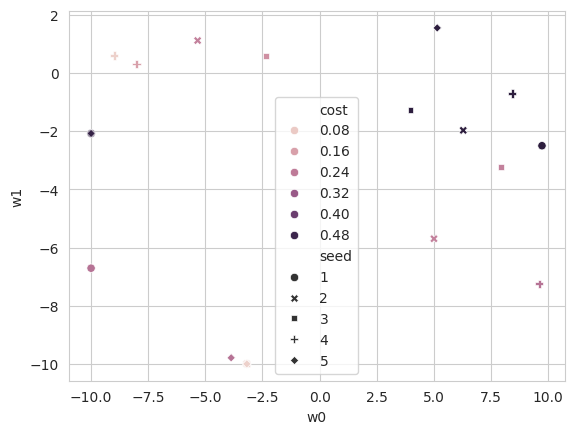

In [3]:
import numpy as np

search_space_dim = 2
sub_df = configs_inc_df[configs_inc_df["search_space_dim"] == search_space_dim]
hp_names = [c for c in sub_df.columns if c.startswith("w")][:search_space_dim]
print(hp_names)
configuration_dicts = [dict(sub_df.iloc[idx][hp_names]) for idx in range(len(sub_df))]
X = np.array([list(d.values()) for d in configuration_dicts])  # (n_samples, n_features)
y = sub_df["cost"].to_numpy()    # class labels (n_samples,)

ax = sns.scatterplot(sub_df, x="w0", y="w1", hue="cost", style="seed")


/scratch/hpc-prf-intexml/cbenjamins/repos/dacboenv/.env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


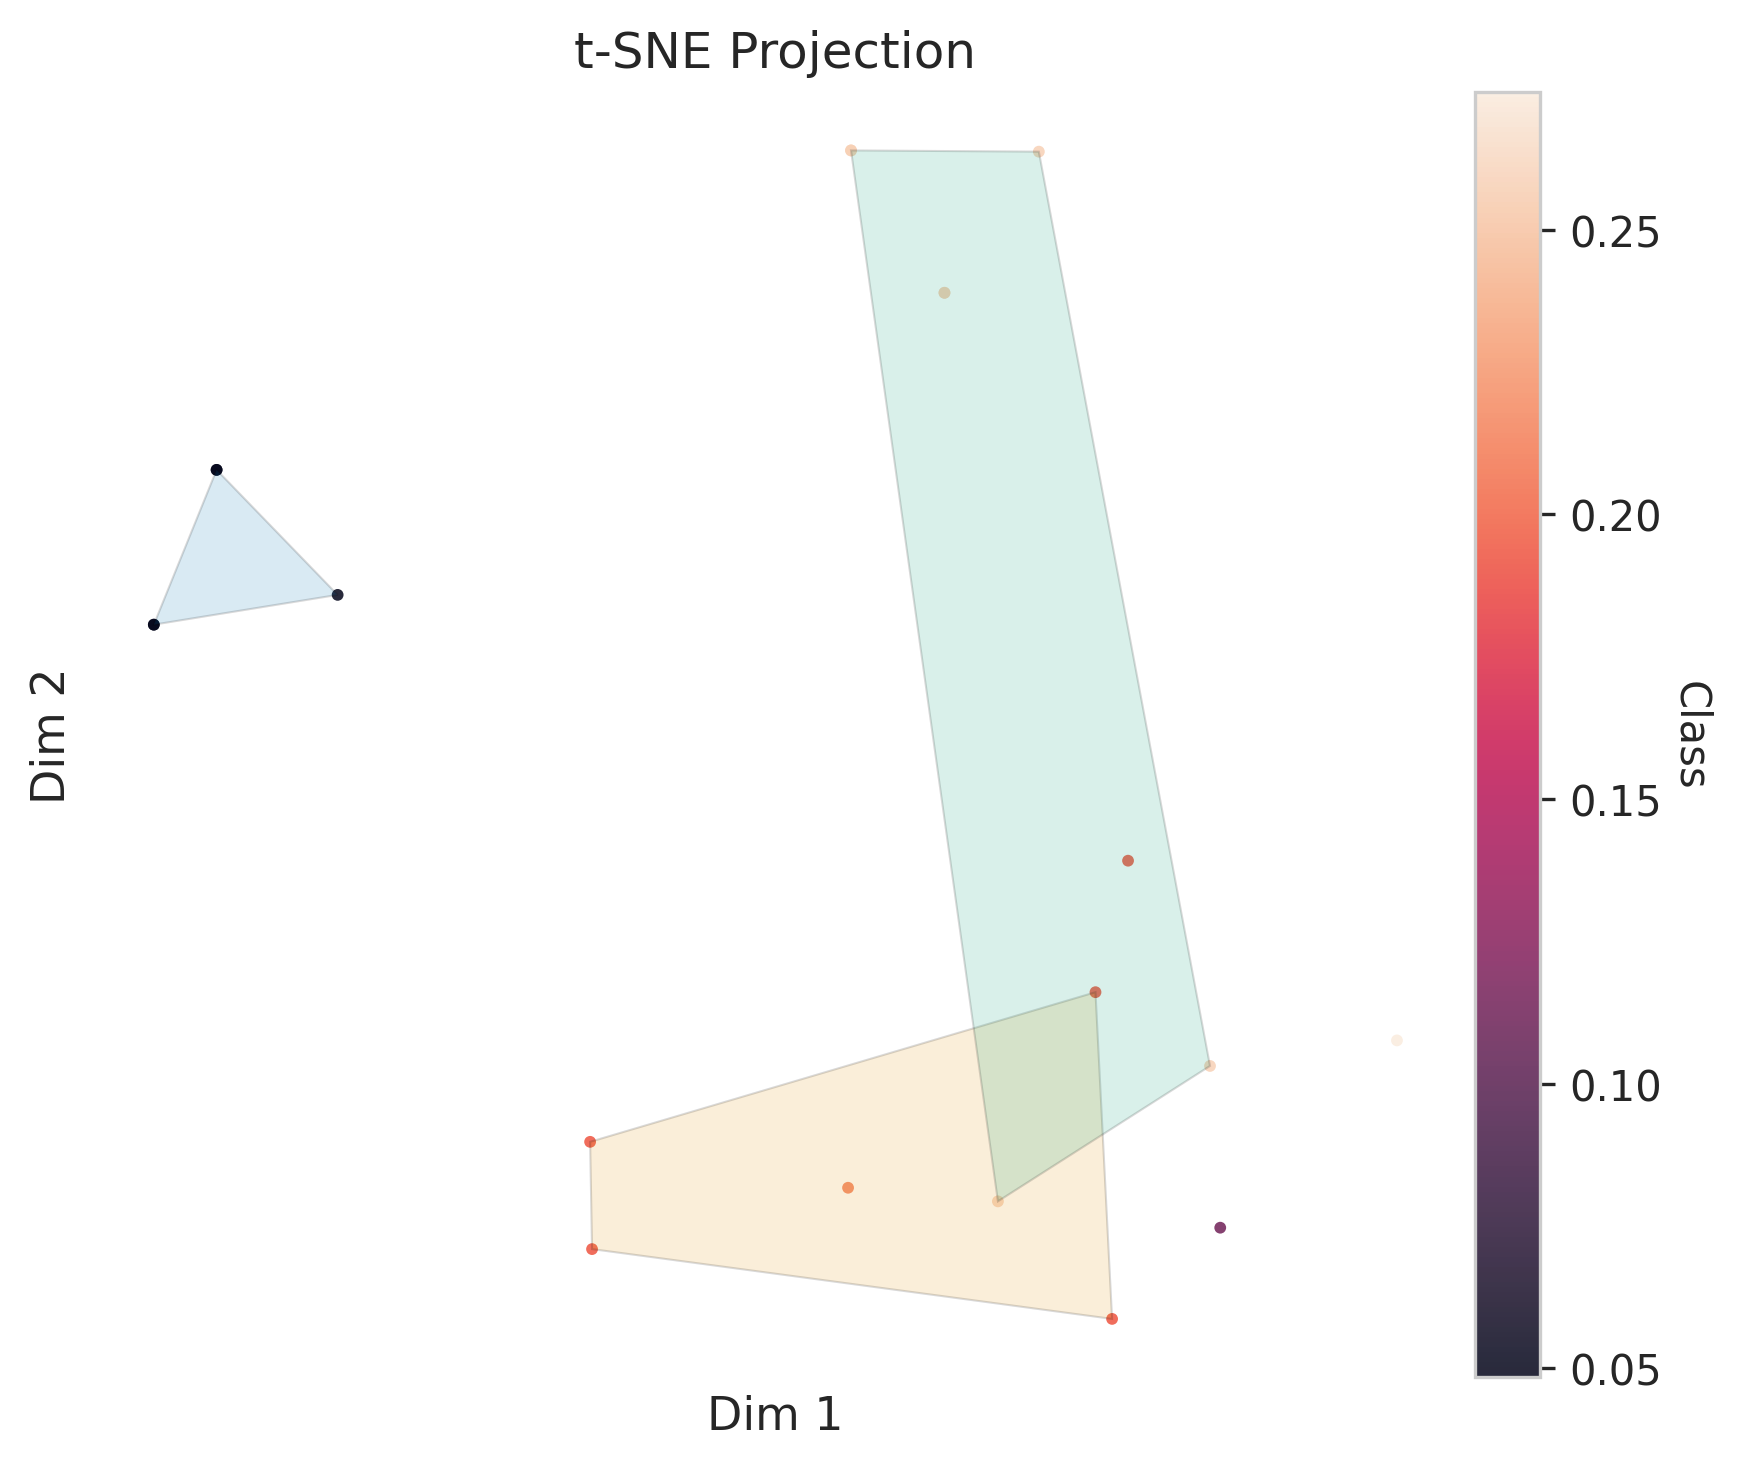

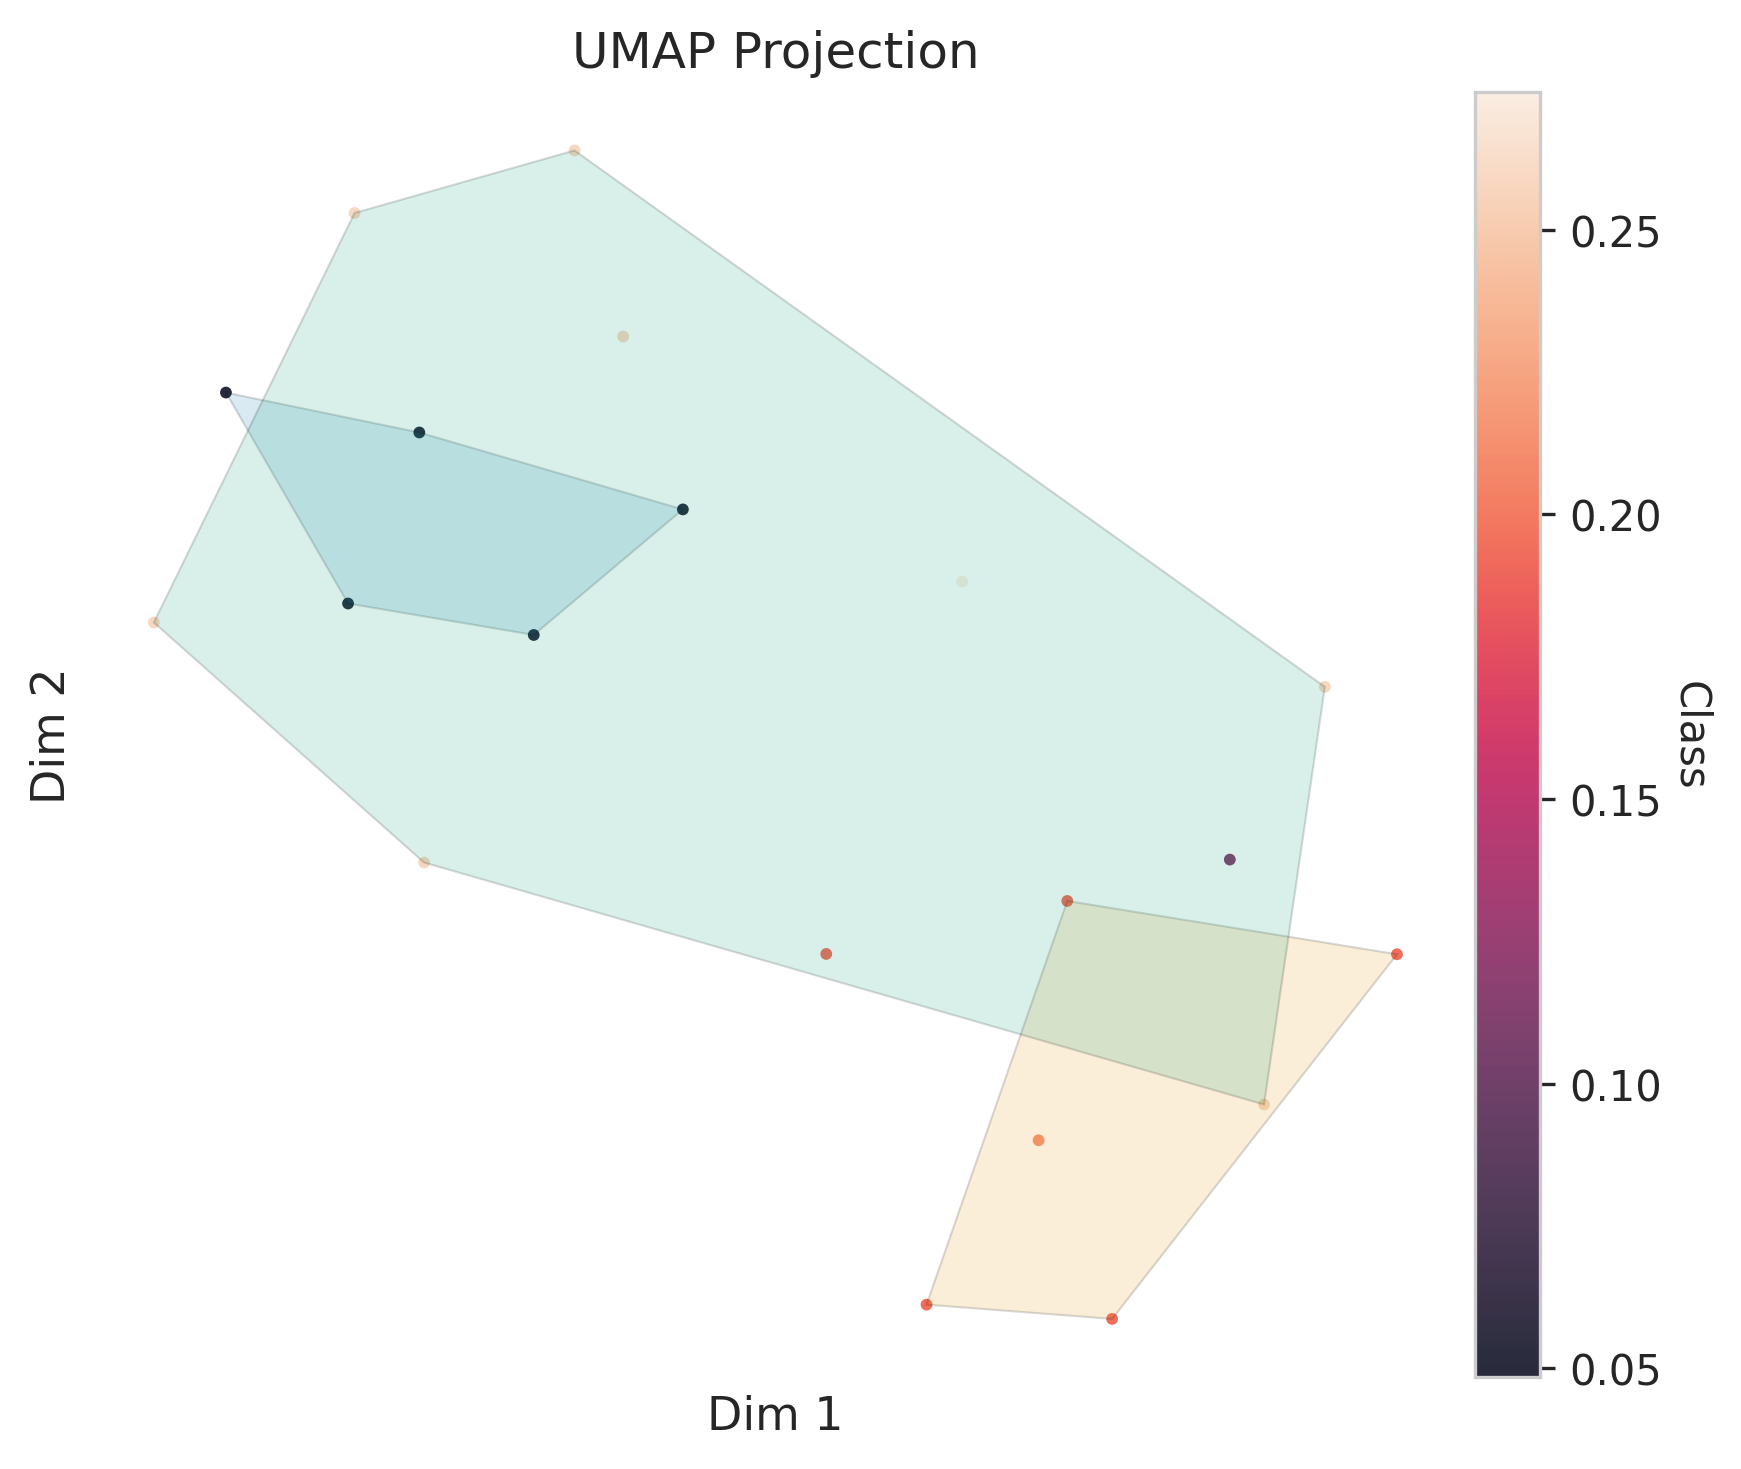

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

from scipy.spatial import ConvexHull

random_state = 455684

# -----------------------------
# Input
# -----------------------------
sub_df = configs_inc_df[configs_inc_df["search_space_dim"] == 8]
hp_names = [c for c in sub_df.columns if c.startswith("w")]
configuration_dicts = [dict(sub_df.iloc[idx][hp_names]) for idx in range(len(sub_df))]
X = np.array([list(d.values()) for d in configuration_dicts])  # (n_samples, n_features)
y = sub_df["cost"].to_numpy()    # class labels (n_samples,)

# -----------------------------
# Normalize + PCA
# -----------------------------
X_norm = StandardScaler().fit_transform(X)

X_pca = PCA(
    n_components=min(50, X_norm.shape[1]),
    random_state=42
).fit_transform(X_norm)

# -----------------------------
# Embeddings
# -----------------------------
tsne = TSNE(
    n_components=2,
    perplexity=5,
    learning_rate="auto",
    init="pca",
    max_iter=2000,
    random_state=random_state,
)

X_tsne = tsne.fit_transform(X_pca)

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    random_state=random_state,
)

X_umap = umap_model.fit_transform(X_pca)

# -----------------------------
# Plot helper
# -----------------------------
def plot_embedding_with_hulls(X_emb, y, title):
    plt.figure(figsize=(6, 5), dpi=300)

    classes = np.unique(y)
    scatter = plt.scatter(
        X_emb[:, 0],
        X_emb[:, 1],
        c=y,
        s=8,
        alpha=0.85,
        linewidths=0,
    )

    # Confidence hulls (convex hulls)
    for cls in classes:
        pts = X_emb[y == cls]
        if pts.shape[0] < 3:
            continue  # hull needs >= 3 points

        hull = ConvexHull(pts)
        hull_pts = pts[hull.vertices]

        plt.fill(
            hull_pts[:, 0],
            hull_pts[:, 1],
            alpha=0.15,
            edgecolor="black",
            linewidth=0.5,
        )

    cbar = plt.colorbar(scatter, pad=0.01)
    cbar.set_label("Class", rotation=270, labelpad=12)

    plt.xlabel("Dim 1", fontsize=11)
    plt.ylabel("Dim 2", fontsize=11)
    plt.title(title, fontsize=12)

    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Plots
# -----------------------------
plot_embedding_with_hulls(X_tsne, y, "t-SNE Projection")
plot_embedding_with_hulls(X_umap, y, "UMAP Projection")
